## Graph attention networks

By Pavlin Poličar 4.10.2020

This notebook is meant to be followed step-by-step and explains how to implement the graph attention mechanism from scratch. Doing so, we also show exactly what _torch_geometric_ does under the hood, and how it simplifies implementations of message passing algorithms.

In [1]:
from math import comb

import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F

import torch_geometric as pyg
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
%matplotlib inline

## Download and load data

We will use a small graph of interactions between FDA-approved drugs from _Stanford Biomedical Network Dataset Collection_ (ChCh-Miner) for our simple example.

In [2]:
!mkdir -p data
!wget http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz -O data/ChCh-Miner_durgbank-chem-chem.tsv.gz
!yes | gunzip data/ChCh-Miner_durgbank-chem-chem.tsv.gz

--2020-10-13 10:45:08--  http://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206802 (202K) [application/x-gzip]
Saving to: ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’

data/ChCh-Miner_dur 100%[===================>] 201.96K   170KB/s    in 1.2s    

2020-10-13 10:45:10 (170 KB/s) - ‘data/ChCh-Miner_durgbank-chem-chem.tsv.gz’ saved [206802/206802]

gzip: data/ChCh-Miner_durgbank-chem-chem.tsv already exists;	not overwritten
yes: standard output: Broken pipe


In [3]:
!head data/ChCh-Miner_durgbank-chem-chem.tsv

DB00862	DB00966
DB00575	DB00806
DB01242	DB08893
DB01151	DB08883
DB01235	DB01275
DB00018	DB00333
DB00201	DB01609
DB00712	DB01418
DB01576	DB04842
DB01609	DB06212


_torch_geometric_ operates on edge lists of node indices (integers), but in the data set, drugs are encoded using an idenfier e.g. DB00966. So we will create a mapping from these IDs to ints.

In [4]:
drug_dict, edge_index = {}, []
drug_index = 0  # we will use this to assign numbers to drugs

with open("data/ChCh-Miner_durgbank-chem-chem.tsv") as f:
    for line in f:
        line = line.rstrip()
        d1, d2 = line.split("\t")
        
        if d1 not in drug_dict:
            drug_dict[d1] = drug_index
            drug_index += 1
        if d2 not in drug_dict:
            drug_dict[d2] = drug_index
            drug_index += 1
        
        edge_index.append([drug_dict[d1], drug_dict[d2]])

print(f"{len(edge_index):,} interactions")

48,514 interactions


In [5]:
edge_index = torch.LongTensor(edge_index).T
edge_index

tensor([[   0,    2,    4,  ..., 1057,  361,  455],
        [   1,    3,    5,  ...,  359,  626,  269]])

We now has something that _torch_geometric_ considers a graph.

### Examine graph

In [6]:
print("Sparsity: %.2f" % (edge_index.size(1) / comb(len(edge_index[0].unique()), 2)))

Sparsity: 0.06


In [7]:
pyg.utils.is_undirected(edge_index)

False

Even though the graph is undirected, we're going to cast it to a directed graph, so this will be one less piece of complexity we will have to worry about.

In [8]:
edge_index = pyg.utils.to_undirected(edge_index)

In [9]:
print(f"{len(edge_index.unique()):,} nodes")

1,514 nodes


### Extract LCC

Many graph-based learning techniques cannot operate on disconnected graphs, so it is standard practice to operate on the largest connected component (LCC). The easiest way to exctract the LCC is to use _networkx_, a popular pure Python library for network analysis.

In [10]:
data = pyg.data.Data(edge_index=edge_index)
nx_data = pyg.utils.to_networkx(data, to_undirected=True)
nx_data

In [11]:
connected_components = list(nx.connected_components(nx_data))
print(f"Graph contains {len(connected_components)} connected components")

Graph contains 3 connected components


In [12]:
lcc_nodes = max(connected_components, key=len)
lcc = nx_data.subgraph(lcc_nodes)
print(f"{lcc.number_of_nodes():,} nodes in LCC")

1,510 nodes in LCC


We've now extracted the LCC of our graph and lost 4 nodes. Let's convert this back into a torch edge list, so we can start fitting our models.

In [13]:
edge_index = pyg.utils.from_networkx(lcc).edge_index
edge_index

tensor([[   0,    0,    0,  ..., 1507, 1508, 1509],
        [   1,    2,    9,  ..., 1011,  346,   45]])

## Prepare data set

As in any machine learning task, we split our data set into a training and validation set. In _torch_geometric_, it is easiest to define boolean masks to indicate which edges belong into each set. Why not use integer indices? Because we can easily attach boolean masks to a _torch_geometric_ `pyg.data.Data` object, which will be indexed properly during mini-batching. Indexing the masks is only possible if their shape matches that of the `edge_index`, so a boolean mask is the way to go.

In [14]:
indices = torch.arange(edge_index.shape[1])
train_idx, val_idx = train_test_split(indices, test_size=0.01)
train_mask, val_mask = torch.zeros_like(indices).bool(), torch.zeros_like(indices).bool()
train_mask[train_idx] = 1
val_mask[val_idx] = 1
train_mask, val_mask

(tensor([True, True, True,  ..., True, True, True]),
 tensor([False, False, False,  ..., False, False, False]))

Because our nodes have no additional features, we generally use a one-hot encoding as features to our model. Obviously, creating a dense identity matrix is very memory-inefficient, and we will quickly run out of memory when working with larger graphs, and unfortunately, `torch_geometric` doesn't yet fully support sparse matrices. So, when dealing with larger graphs, we often use random features instead.

In [15]:
data = pyg.data.Data(edge_index=edge_index, train_mask=train_mask, val_mask=val_mask)
data.x = torch.randn(data.num_nodes, 128)
data

Data(edge_index=[2, 97024], train_mask=[97024], val_mask=[97024], x=[1510, 128])

## Attention mechanism

We will first see how to propagate information for a single node. This is easily done using an edge list, which we can easily obtain by using the CSR format of sparse matrices.

In [16]:
import torch_sparse

In [17]:
adj = torch_sparse.SparseTensor(row=edge_index[0], col=edge_index[1])
indptr, indices, _ = adj.csr()
indptr, indices

(tensor([    0,   133,   181,  ..., 97022, 97023, 97024]),
 tensor([   1,    2,    9,  ..., 1011,  346,   45]))

In [18]:
# Select some arbitrary node with a small amount of neighbors (for demonstration purposes)
node_idx = 1371

# Get that nodes neighbors
neighbors = indices[indptr[node_idx] : indptr[node_idx + 1]]
neighbors

tensor([ 378,  412,  876, 1370, 1391])

### Calculate for single node

It will be easiest to understand the attention mechanism if we first focus on a single node. We will then move on to using more nodes, but let's start simple.

In [19]:
x = data.x
edge_index = data.edge_index

Let's start by defining a few variables that will help us later on. For the out dimension, we'll arbitrarily choose 16.

In [20]:
in_features = x.shape[1]
out_features = 16

The attention update equation is given by 

$$\sigma \left( \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W} x_j + b \right)$$

where $\alpha_{ij}$ are attention coefficients we'll define later. So the parameters we need to learn here are the weight matrix $\mathbf{W}$ and the bias term.

In [21]:
weight = torch.Tensor(torch.rand(in_features, out_features))
bias = torch.Tensor(torch.rand(1))

To calculate the attention coefficients $\alpha_{ij}$, we need to evaluate the following expression

$$\text{LeakyReLU} \left( \mathbf{a}^T \left[ \mathbf{W} x_i || \mathbf{W} x_j \right] \right).$$

Then, we apply a softmax to these values to obtain the final attention coefficients.

One clever trick we can use here is to split the $\mathbf{a}$ vector into two vectors: $\mathbf{a}_l$ and $\mathbf{a}_r$. Then, we don't need to perform the actual concatenation, but can separate them separately. We can obtain the final $\alpha_{ij}$ coefficients by summing together $\mathbf{a}_l^T (\mathbf{W} x_i)$ and $\mathbf{a}_r^T (\mathbf{W} x_j)$. It is trivial to show that these expressions are equivalent.

In [22]:
# Split the attention vector for efficiency
att_l = torch.Tensor(torch.rand(1, out_features))
att_r = torch.Tensor(torch.rand(1, out_features))

To get $\mathbf{W}x_i$ and $\mathbf{W}x_j$, we can compute the entire matrix, then index as needed.

In [26]:
x_lin = x @ weight
x_lin.shape

torch.Size([1510, 16])

We calculate the left attention coefficients for our chosen nodes' neighbors.

In [27]:
alpha_l = torch.sum(x_lin[neighbors] * att_r, dim=1)
alpha_l

tensor([-25.0890, -18.8468,  66.0441,  28.9065,  15.8225])

And the same for our chosen node itself.

In [28]:
alpha_r = torch.sum(x_lin[node_idx] * att_r, dim=1)
alpha_r

tensor([-33.1518])

To get the final unnormalized $\alpha$ coefficients, we sum the two together.

In [29]:
alpha = alpha_l + alpha_r
alpha

tensor([-58.2408, -51.9986,  32.8922,  -4.2453, -17.3293])

In [30]:
alpha = F.leaky_relu(alpha, negative_slope=0.2)
alpha

tensor([-11.6482, -10.3997,  32.8922,  -0.8491,  -3.4659])

We softmax the $\alpha$ coefficients, so that the neighbors feature vectors will be aggregated by effectively a weighted sum.

In [31]:
alpha = F.softmax(alpha, dim=0)
alpha

tensor([4.5327e-20, 1.5796e-19, 1.0000e+00, 2.2200e-15, 1.6214e-16])

In [32]:
Z = torch.sum(alpha.unsqueeze(-1) * x_lin[neighbors], dim=0)
Z += bias
Z

tensor([15.5408, 11.9656, 12.1488, 13.8929, 15.3638,  8.5955, 11.9788, 11.3473,
        10.8255, 16.4858, 13.3566,  5.7238, 11.7674, 11.1141,  5.7133,  7.9743])

In [33]:
Z = F.relu(Z)
Z

tensor([15.5408, 11.9656, 12.1488, 13.8929, 15.3638,  8.5955, 11.9788, 11.3473,
        10.8255, 16.4858, 13.3566,  5.7238, 11.7674, 11.1141,  5.7133,  7.9743])

We now have the new latent representation for our chosen node 1371 after applying the attention mechanism to its neighbors.

### Calculate for all nodes

Now that we understand how the latent state is calculated for a single node, we can move on to efficiently calculating the latent state for all the nodes. We begin the same way as before, defining our dimensions and parameters.

In [34]:
x = data.x
edge_index = data.edge_index

In [35]:
in_features = x.shape[1]
out_features = 16

In [36]:
# Split the linear layer because we only want to apply the bias at the end
weight = torch.Tensor(torch.rand(in_features, out_features))
bias = torch.Tensor(torch.rand(1))

In [41]:
# Split the attention vector for efficiency
att_l = torch.Tensor(torch.rand(1, out_features))
att_r = torch.Tensor(torch.rand(1, out_features))

In [42]:
x_lin = x @ weight
x_lin.shape

torch.Size([1510, 16])

This time, we'll calculate the partial attention coefficients for all the nodes, since we'll eventually need them all.

In [43]:
alpha_l = torch.sum(x_lin * att_l, dim=1)
alpha_r = torch.sum(x_lin * att_r, dim=1)

Now, we'll index the partial alpha coefficients using our edge index. So the source nodes (`edge_index[0]`) will be matched with their target nodes (`edge_index[1]`).

In [44]:
alpha = alpha_l[edge_index[0]] + alpha_r[edge_index[1]]
alpha.shape

torch.Size([97024])

We see that we have as many coefficients as there are edges in our graph.

In [45]:
alpha

tensor([-17.2143, -58.0323,   4.7199,  ...,  -1.8413, -54.0889, 128.6888])

In [46]:
alpha = F.leaky_relu(alpha, negative_slope=0.2)
alpha

tensor([ -3.4429, -11.6065,   4.7199,  ...,  -0.3683, -10.8178, 128.6888])

To apply the softmax, we need to find each target node, and only perform the softmax over the nodes connected to it. Thankfully, torch_geometric has a helper function that does exactly this.

In [47]:
alpha = pyg.utils.softmax(alpha, edge_index[1])
alpha

tensor([0.0000e+00, 4.3496e-42, 0.0000e+00,  ..., 9.1248e-34, 8.8335e-29,
        1.0685e-39])

We can check that the softmax indeed did exactly what we wanted.

In [48]:
alpha[edge_index[1] == node_idx].sum()

tensor(1.)

Then, we'll take each representation of the source nodes, and multiply them with their attention coefficients.

In [49]:
z_j = alpha.unsqueeze(-1) * x_lin[edge_index[0]]
z_j.shape

torch.Size([97024, 16])

Finally, we need to aggregate these together to obtain the final latent representation. To do this, we'll have to iterate over each node, find all their neighbors, and sum their representations together. This is fairly easy to do with a simple for loop.

In [50]:
Z = torch.zeros(data.num_nodes, z_j.shape[1])
for i, j in enumerate(edge_index[1]):
    Z[j] += z_j[i]
Z

tensor([[11.4580, 18.4053, 19.2791,  ..., 16.0059, 14.6000, 20.7098],
        [21.2507, 12.1373, 13.8304,  ..., 17.2289, 13.0378, 16.1956],
        [21.2507, 12.1373, 13.8304,  ..., 17.2289, 13.0378, 16.1956],
        ...,
        [-3.6347,  3.3949,  2.0840,  ...,  0.5942,  3.5522,  2.3154],
        [-8.9762, -2.7442, -6.4423,  ..., -9.4922, -8.6632, -8.1590],
        [12.7997, 12.5907, 12.1301,  ..., 14.8058, 12.4967,  7.9908]])

However, for loops are fairly slow and non-pythonic, and we have torch_scatter, which does this for us efficiently, and on the GPU! This is exactly what torch_geometric does under the hood.

In [51]:
import torch_scatter

In [52]:
Z1 = torch_scatter.scatter(z_j, edge_index[1], dim=0, reduce="add")
Z1.shape

torch.Size([1510, 16])

In [53]:
Z1

tensor([[11.4580, 18.4053, 19.2791,  ..., 16.0059, 14.6000, 20.7098],
        [21.2507, 12.1373, 13.8304,  ..., 17.2289, 13.0378, 16.1956],
        [21.2507, 12.1373, 13.8304,  ..., 17.2289, 13.0378, 16.1956],
        ...,
        [-3.6347,  3.3949,  2.0840,  ...,  0.5942,  3.5522,  2.3154],
        [-8.9762, -2.7442, -6.4423,  ..., -9.4922, -8.6632, -8.1590],
        [12.7997, 12.5907, 12.1301,  ..., 14.8058, 12.4967,  7.9908]])

Notice that the results are exactly the same as with our for loop before, but much faster.

The final step is to, again, to add the bias, and apply a non-linearity.

In [54]:
Z += bias
Z

tensor([[11.9567, 18.9040, 19.7778,  ..., 16.5046, 15.0986, 21.2085],
        [21.7494, 12.6359, 14.3291,  ..., 17.7276, 13.5365, 16.6943],
        [21.7494, 12.6359, 14.3291,  ..., 17.7276, 13.5365, 16.6943],
        ...,
        [-3.1360,  3.8936,  2.5827,  ...,  1.0929,  4.0509,  2.8141],
        [-8.4776, -2.2456, -5.9436,  ..., -8.9935, -8.1645, -7.6603],
        [13.2984, 13.0894, 12.6288,  ..., 15.3045, 12.9954,  8.4895]])

In [55]:
Z = F.relu(Z)
Z

tensor([[11.9567, 18.9040, 19.7778,  ..., 16.5046, 15.0986, 21.2085],
        [21.7494, 12.6359, 14.3291,  ..., 17.7276, 13.5365, 16.6943],
        [21.7494, 12.6359, 14.3291,  ..., 17.7276, 13.5365, 16.6943],
        ...,
        [ 0.0000,  3.8936,  2.5827,  ...,  1.0929,  4.0509,  2.8141],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [13.2984, 13.0894, 12.6288,  ..., 15.3045, 12.9954,  8.4895]])

### Putting it into torch_geometric

Thankfully, we don't have to do these mental gymnastics with `edge_indices` and figure out how to aggregate the latent representations, as we have _torch_geometric_ that does this automatically for us. In fact, torch_geometric does exactly the same thing as we've done above, but provides a nicer interface. Let's rewrite our graph attention layer with _torch_geometric_.

In [57]:
class GATConv(pyg.nn.MessagePassing):
    def __init__(self):
        super().__init__(aggr="add", node_dim=0)
        self.weight = weight
        self.bias = bias
        self.att_l = att_l
        self.att_r = att_r
        
    def forward(self, x, edge_index):
        x_lin = x @ self.weight
        
        alpha_l = torch.sum(x_lin * self.att_l, dim=1)
        alpha_r = torch.sum(x_lin * self.att_r, dim=1)
        
        out = self.propagate(edge_index, x=x_lin, alpha=(alpha_l, alpha_r))
        
        out += self.bias
        
        return out
        
    def message(self, x_j, alpha_i, alpha_j, index):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = pyg.utils.softmax(alpha, index)
        return alpha.unsqueeze(-1) * x_j
    
conv = GATConv()
F.relu(conv(x, edge_index))

tensor([[11.9567, 18.9040, 19.7778,  ..., 16.5046, 15.0986, 21.2085],
        [21.7494, 12.6359, 14.3291,  ..., 17.7276, 13.5365, 16.6943],
        [21.7494, 12.6359, 14.3291,  ..., 17.7276, 13.5365, 16.6943],
        ...,
        [ 0.0000,  3.8936,  2.5827,  ...,  1.0929,  4.0509,  2.8141],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [13.2984, 13.0894, 12.6288,  ..., 15.3045, 12.9954,  8.4895]])

Notice that the result is exaclty the same as before! But we didn't have to worry about any indices or aggregation.

## Multi-head attention

Up until now, we have been looking at a single vector of attention coefficients. More commonly, we use multiple attention "heads". This means we instead use several attention vectors to create $K$ latent representations. The core idea remains entirely the same.

In [58]:
x = data.x
edge_index = data.edge_index

In [59]:
in_features = x.shape[1]
out_features = 16
k_heads = 3

In [60]:
weight = torch.Tensor(torch.rand(in_features, k_heads * out_features))
bias = torch.Tensor(torch.rand(1, k_heads, 1))

In [61]:
# Split the attention vector for efficiency
att_l = torch.Tensor(torch.rand(1, k_heads, out_features))
att_r = torch.Tensor(torch.rand(1, k_heads, out_features))
att_l.shape, att_r.shape

(torch.Size([1, 3, 16]), torch.Size([1, 3, 16]))

In [62]:
x_lin = (x @ weight).view(-1, k_heads, out_features)
x_lin.shape

torch.Size([1510, 3, 16])

This time, we'll calculate the partial attention coefficients for all the nodes, since we'll eventually need them all.

In [63]:
alpha_l = torch.sum(x_lin * att_l, dim=2)
alpha_r = torch.sum(x_lin * att_r, dim=2)
alpha_l.shape, alpha_r.shape

(torch.Size([1510, 3]), torch.Size([1510, 3]))

Now, we'll index the partial alpha coefficients using our edge index. So the source nodes (`edge_index[0]`) will be matched with their target nodes (`edge_index[1]`).

In [64]:
alpha = alpha_l[edge_index[0]] + alpha_r[edge_index[1]]
alpha.shape

torch.Size([97024, 3])

We see that we have as many coefficients as there are edges in our graph.

In [65]:
alpha

tensor([[ -8.3418, -32.9474, -11.1034],
        [-46.2163, -37.1257, -38.8225],
        [ 14.6325,  -3.8859,  -6.5477],
        ...,
        [  7.6691,  18.0014,   7.9314],
        [-24.7279, -38.5599, -56.4428],
        [115.3526,  97.1688,  92.3886]])

In [66]:
alpha = F.leaky_relu(alpha, negative_slope=0.2)
alpha

tensor([[ -1.6684,  -6.5895,  -2.2207],
        [ -9.2433,  -7.4251,  -7.7645],
        [ 14.6325,  -0.7772,  -1.3095],
        ...,
        [  7.6691,  18.0014,   7.9314],
        [ -4.9456,  -7.7120, -11.2886],
        [115.3526,  97.1688,  92.3886]])

In [67]:
alpha = pyg.utils.softmax(alpha, edge_index[1])
alpha

tensor([[0.0000e+00, 1.9618e-44, 0.0000e+00],
        [4.7514e-33, 5.6753e-43, 4.4842e-44],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [2.1604e-34, 1.0964e-26, 3.2377e-25],
        [7.7440e-33, 2.0522e-27, 2.7509e-19],
        [2.6476e-33, 2.6182e-41, 1.5334e-37]])

In [68]:
alpha[edge_index[1] == node_idx, 0].sum()

tensor(1.)

In [69]:
z_j = alpha.unsqueeze(-1) * x_lin[edge_index[0]]
z_j.shape

torch.Size([97024, 3, 16])

In [70]:
Z = torch_scatter.scatter(z_j, edge_index[1], dim=0, reduce="add")
Z.shape

torch.Size([1510, 3, 16])

In [71]:
Z += bias
Z = F.relu(Z)

In [72]:
Z.shape

torch.Size([1510, 3, 16])

We have a 16 dimensional feature vector for each of the attention heads. Usually, we just concatenate these feature vectors, or average them, depending on the circumstance. Here, simple concatenation will be fine.

In [73]:
Z = Z.view(-1, k_heads * out_features)
Z

tensor([[24.7915, 15.5588, 17.4669,  ..., 20.5410, 19.1474, 16.8559],
        [19.8680, 16.8588, 12.8395,  ..., 15.5043, 14.0698, 11.6519],
        [19.8680, 16.8588, 12.8395,  ..., 15.5043, 14.0698, 11.6519],
        ...,
        [ 0.0000,  2.1560,  2.1620,  ...,  0.0000,  2.3311,  0.6926],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [20.0690,  8.7982,  7.3200,  ...,  8.7377,  8.0116, 13.0630]])

In [74]:
Z.shape

torch.Size([1510, 48])

# Putting it all together

We now have a good understanding of the attention mechanism and _torch_geometric_. So let's put all this knowledge to use and actually learn some embeddings for our little graph.

We'll implement a two-layer GNN using multi-head attention layers. We'll add a couple of things to our GAT implementation. First, we'll improve the initialization a little bit and use glorot init instead of random normal, which tends to improve training. Secondly, we'll add a `concat` parameter, which will indicate whether we want to concat the output of the different attention heads, or just simlpy average their outputs. This is often done at the final layer to reduce the dimensionality of the embedding.

In [75]:
from torch_geometric.nn.inits import glorot, zeros


class GATConv(pyg.nn.MessagePassing):
    def __init__(self, in_features, out_features, k_heads=1, concat=True):
        super().__init__(aggr="add", node_dim=0)
        self.in_features = in_features
        self.out_features = out_features
        self.k_heads = k_heads
        self.concat = concat
        
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features * k_heads))
        if concat:
            self.bias = torch.nn.Parameter(torch.Tensor(k_heads * out_features))
        else:
            self.bias = torch.nn.Parameter(torch.Tensor(1, out_features))
            
        self.att_l = torch.nn.Parameter(torch.Tensor(1, k_heads, out_features))
        self.att_r = torch.nn.Parameter(torch.Tensor(1, k_heads, out_features))
        
        self.reset_parameters()
        
    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)
        
    def forward(self, x, edge_index):
        x_lin = (x @ self.weight).view(-1, self.k_heads, self.out_features)
        
        alpha_l = torch.sum(x_lin * self.att_l, dim=2)
        alpha_r = torch.sum(x_lin * self.att_r, dim=2)
        
        out = self.propagate(edge_index, x=x_lin, alpha=(alpha_l, alpha_r))
        
        if self.concat:
            out = out.view(-1, self.k_heads * self.out_features)
        else:
            out = out.mean(dim=1)
        
        out += self.bias
        
        return out
        
    def message(self, x_j, alpha_i, alpha_j, index):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = pyg.utils.softmax(alpha, index)
        return alpha.unsqueeze(-1) * x_j

### Define the model

To check how well our model is doing, we want to validate performance using a set of real, existing edges, as well as an equal number of non-existent edges. To get these non-existent edges, we perform negative sampling, and attach these to our data object.

In [76]:
data.val_neg_edge_index = negative_sampling(data.edge_index, num_neg_samples=data.val_mask.sum())

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [78]:
class Encoder(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, k_heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, k_heads=k_heads)
        self.conv2 = GATConv(hidden_dim * k_heads, out_dim, k_heads=k_heads, concat=False)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

In [79]:
model = GAE(Encoder(data.num_features, hidden_dim=32, out_dim=16, k_heads=8)).to(device)
model

GAE(
  (encoder): Encoder(
    (conv1): GATConv()
    (conv2): GATConv()
  )
  (decoder): InnerProductDecoder()
)

In [80]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [81]:
training_losses, validation_losses, val_auc, val_ap = [], [], [], []

for epoch in range(400):
    model.train()
    optimizer.zero_grad()
    
    # train_pos_edge_index contains the true edges, i.e. edges that exist, in the training set
    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    x = data.x.to(device)
    
    # z holds the node embeddings
    z = model.encode(x, train_pos_edge_index)
    # while the link prediction is performed inside this handy model.recon_loss function
    loss = model.recon_loss(z, train_pos_edge_index)
    training_loss = loss.item()
    loss.backward()
    optimizer.step()

    model.eval()
    
    # To validate our model, we first compute node embeddings for each node using the training
    # set edges.
    train_pos_edge_index = data.edge_index[:, data.train_mask].to(device)
    # Our model's predictions will then be checked against the true, existing validation edges
    # stored in val_pos_edge_index
    val_pos_edge_index = data.edge_index[:, data.val_mask].to(device)

    with torch.no_grad():
        z = model.encode(data.x.to(device), train_pos_edge_index)
        validation_loss = model.recon_loss(z, val_pos_edge_index).item()
    
    auc, ap = model.test(z, val_pos_edge_index, data.val_neg_edge_index)
    
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    val_auc.append(auc)
    val_ap.append(ap)
    
    if (epoch + 1) % 20 == 0:
        print("Epoch: {:03d}, Training loss: {:.4f}, Validation loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}".format(
            epoch + 1, training_loss, validation_loss, auc, ap))

Epoch: 020, Training loss: 1.2700, Validation loss: 1.2720, AUC: 0.7296, AP: 0.7207
Epoch: 040, Training loss: 1.1052, Validation loss: 1.1526, AUC: 0.8257, AP: 0.8115
Epoch: 060, Training loss: 1.0635, Validation loss: 1.1167, AUC: 0.8785, AP: 0.8752
Epoch: 080, Training loss: 0.9959, Validation loss: 1.0675, AUC: 0.8977, AP: 0.9009
Epoch: 100, Training loss: 0.9617, Validation loss: 1.0413, AUC: 0.9210, AP: 0.9271
Epoch: 120, Training loss: 0.9340, Validation loss: 1.0225, AUC: 0.9315, AP: 0.9351
Epoch: 140, Training loss: 0.9130, Validation loss: 0.9829, AUC: 0.9386, AP: 0.9380
Epoch: 160, Training loss: 0.8875, Validation loss: 0.9973, AUC: 0.9512, AP: 0.9502
Epoch: 180, Training loss: 0.8743, Validation loss: 0.9600, AUC: 0.9470, AP: 0.9483
Epoch: 200, Training loss: 0.8514, Validation loss: 1.0092, AUC: 0.9589, AP: 0.9607
Epoch: 220, Training loss: 0.8300, Validation loss: 0.9487, AUC: 0.9619, AP: 0.9639
Epoch: 240, Training loss: 0.8306, Validation loss: 0.9931, AUC: 0.9667, AP:

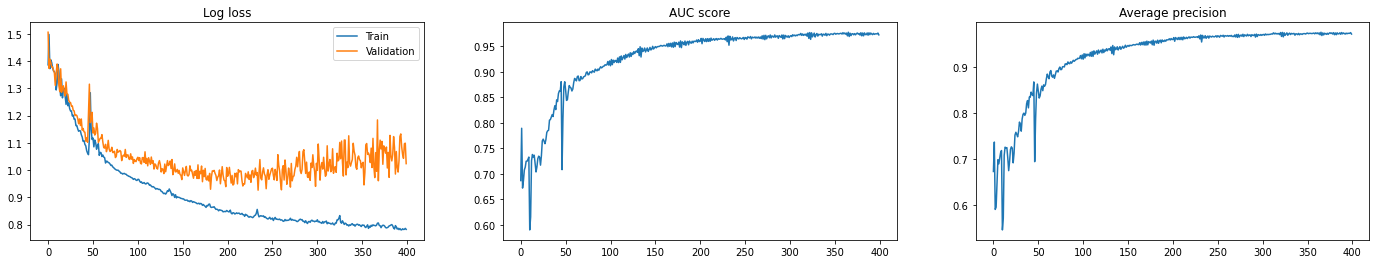

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 4))

ax[0].set_title("Log loss")
ax[0].plot(training_losses, label="Train")
ax[0].plot(validation_losses, label="Validation")
ax[0].legend()

ax[1].set_title("AUC score")
ax[1].plot(val_auc)

ax[2].set_title("Average precision")
ax[2].plot(val_ap)

#### Inspect node embeddings

Now that our model is trained, we can visualize the node embeddings. We decided that our node embeddings are 16-dimensional. We can easily convert this to a 2D visualization using any visualization algorithm. We will not go into any interpretation here, as the point of the notebook is to demonstrate how to actually fit these models.

In [83]:
embedding = z.cpu().detach().numpy()
embedding

array([[ 0.2754068 , -0.8863642 , -0.07997369, ...,  1.3031423 ,
        -0.7492251 ,  0.848655  ],
       [-0.11989047, -0.2723707 , -0.44147307, ...,  0.8393395 ,
        -0.50665414,  0.3370611 ],
       [ 0.07377554, -0.8428259 ,  0.10095653, ...,  0.06597434,
        -0.6916208 ,  0.9440733 ],
       ...,
       [-0.08033479, -0.1174776 ,  0.2190264 , ..., -0.19448355,
         0.21716231, -0.2517559 ],
       [ 0.21717554, -0.5968388 ,  0.29101956, ..., -0.10746823,
         0.20049906,  0.00844433],
       [-0.13049218,  0.04450371, -0.25068897, ...,  0.12702832,
         0.3797775 , -0.5494634 ]], dtype=float32)

In [84]:
from openTSNE import TSNE

tsne_embedding = TSNE(exaggeration=2, n_jobs=4).fit(embedding)

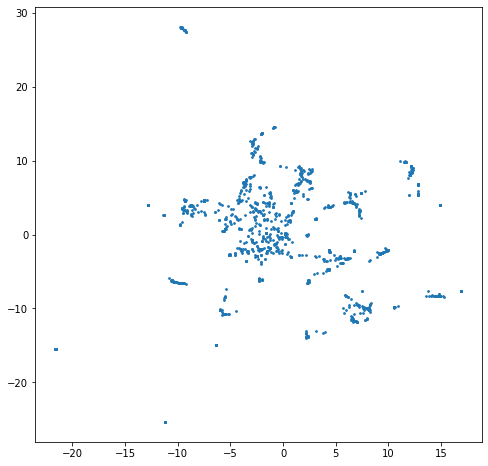

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=3)